In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from torchvision.datasets import MNIST

from dataset_builder import *

In [39]:
train_loader, test_loader, mnist = prepare_semisupervised_mnist_data(subset_ratio = 0.2, train_ratio=0.75)

Dataset preparato:
- Subset totale: 12000 campioni
- Training set: 9000 campioni
- Test set: 3000 campioni
- Batch size: 32


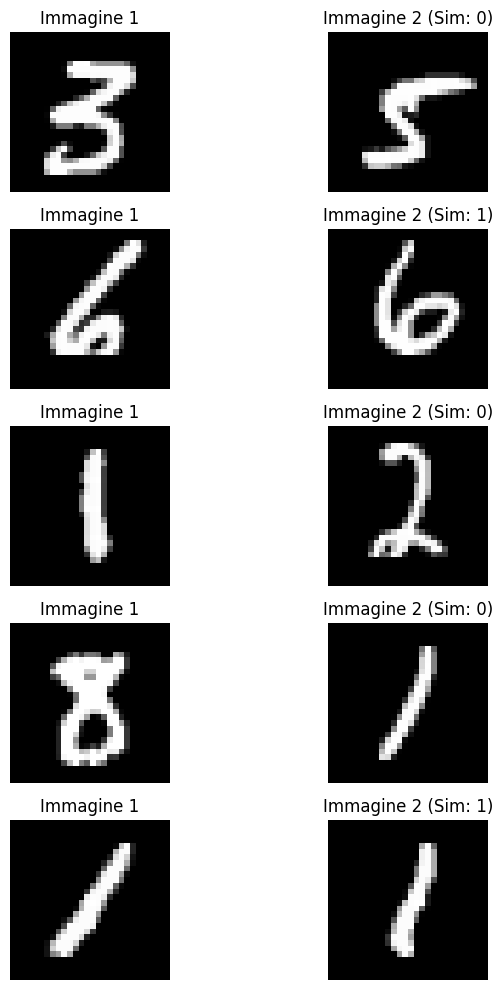

In [89]:
visualize_pairs(train_loader.dataset)

In [90]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0, w = 1): # prova ad aumentare il margin
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.w = w
    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                    (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))*self.w

      return loss_contrastive

In [91]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size = 2):
        super(SiameseNetwork, self).__init__()

        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, embedding_size)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [92]:
def train_model(model, train_loader, optimizer, criterion, epochs):

    counter = []
    loss_history = [] 
    iteration_number= 0

    for epoch in range(epochs):

        for i, (img0, img1, label) in enumerate(train_loader, 0):

            optimizer.zero_grad()
            output1, output2 = model(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 10 == 0 :
                print(f"Epoch {epoch} batch {i}\nloss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    
    return (counter, loss_history)

In [93]:
net = SiameseNetwork(embedding_size = 128)
criterion = ContrastiveLoss(margin=3.0, w = 3)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

counter, loss_history = train_model(net, train_loader, optimizer, criterion, epochs = 10)


Epoch 0 batch 0
loss 14.362251281738281

Epoch 0 batch 10
loss 8.723295211791992

Epoch 0 batch 20
loss 9.114797592163086

Epoch 0 batch 30
loss 6.916492462158203

Epoch 0 batch 40
loss 7.226381778717041

Epoch 0 batch 50
loss 7.400119781494141

Epoch 0 batch 60
loss 7.113103866577148

Epoch 0 batch 70
loss 7.555895805358887

Epoch 0 batch 80
loss 7.582853317260742

Epoch 0 batch 90
loss 7.501828193664551

Epoch 0 batch 100
loss 7.958832740783691

Epoch 0 batch 110
loss 8.109444618225098

Epoch 0 batch 120
loss 7.273358345031738

Epoch 0 batch 130
loss 7.762340545654297

Epoch 0 batch 140
loss 7.465241432189941

Epoch 0 batch 150
loss 7.250109672546387

Epoch 0 batch 160
loss 7.0209856033325195

Epoch 0 batch 170
loss 7.723594665527344

Epoch 0 batch 180
loss 5.8655524253845215

Epoch 0 batch 190
loss 7.100172996520996

Epoch 0 batch 200
loss 6.918853282928467

Epoch 0 batch 210
loss 7.888096809387207

Epoch 0 batch 220
loss 7.279934406280518

Epoch 0 batch 230
loss 6.9919753074646

Ep

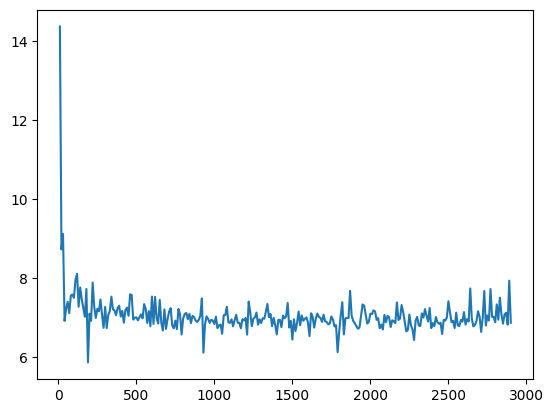

In [94]:
plt.plot(counter, loss_history)

In [43]:
def test_trained_model(model, dataset, num_examples=5):
    """
    Testa il modello trainato su alcuni esempi
    """
    giuste = 0
    sbagliate = 0
    model.eval()
    device = next(model.parameters()).device
    
    print(f"Test del modello testato su {num_examples} esempi:")
    print("-" * 60)
    
    for i in range(num_examples):
        img1, img2, true_label = dataset[i]
        
        # Aggiungi dimensione batch
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            similarity = torch.exp(-euclidean_distance)
            predicted_label = 1 if similarity.item() > 0.5 else 0
        
        if predicted_label == true_label:
            giuste +=1
        else:
            sbagliate +=1
    
    print("Il modello ne ha beccate: " + str(giuste))
    print("Il modello ne ha sbagliate: " + str(sbagliate))



In [100]:
test_trained_model(net, test_loader.dataset, num_examples=50)
print("porcodio")

Test del modello testato su 50 esempi:
------------------------------------------------------------
Il modello ne ha beccate: 30
Il modello ne ha sbagliate: 20
porcodio
